In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [12]:

def extract_keypoints_and_descriptors(images):
    # Extract ORB keypoints and descriptors from images.
    orb = cv2.ORB_create(nfeatures=5000)
    keypoints, descriptors = [], []

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = orb.detectAndCompute(gray, None)
        keypoints.append(kp)
        descriptors.append(des)

        # Draw keypoints on the image
        img_with_kp = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0))
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Detected Keypoints")
        plt.show()

    return keypoints, descriptors

def match_keypoints(des1, des2, img1, img2, kp1, kp2):
    # Match keypoints between two images using Brute Force Matcher.
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)[:50]  # Take the best 50 matches

    # Draw matches
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Feature Matches")
    plt.show()

    return matches

def warp_and_stitch(base_img, new_img, kp1, kp2, matches):
    # Compute homography and warp images for proper stitching.
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute homography matrix
    H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)

    # Get image sizes
    h1, w1 = base_img.shape[:2]
    h2, w2 = new_img.shape[:2]

    # Warp new_img onto the base panorama
    corners_new = np.float32([[0, 0], [w2, 0], [w2, h2], [0, h2]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners_new, H)

    # Compute the bounding box
    x_min, y_min = np.int32(transformed_corners.min(axis=0).flatten())
    x_max, y_max = np.int32(transformed_corners.max(axis=0).flatten())

    width = max(x_max, w1) - min(x_min, 0)
    height = max(y_max, h1) - min(y_min, 0)

    # Adjust transformation matrix
    translation_matrix = np.array([[1, 0, -min(x_min, 0)], [0, 1, -min(y_min, 0)], [0, 0, 1]])
    H = translation_matrix @ H

    # Warp the new image
    panorama = cv2.warpPerspective(new_img, H, (width, height))

    # Place base_img correctly
    y_offset = -min(y_min, 0)
    x_offset = -min(x_min, 0)
    panorama[y_offset:y_offset + h1, x_offset:x_offset + w1] = base_img

    return panorama

def stitch_images(image_paths):
    # Main function to read images, extract keypoints, match, and stitch them.
    images = [cv2.imread(img) for img in image_paths]

    keypoints, descriptors = extract_keypoints_and_descriptors(images)

    panorama = images[0]

    for i in range(1, len(images)):
        matches = match_keypoints(descriptors[i-1], descriptors[i], images[i-1], images[i], keypoints[i-1], keypoints[i])
        panorama = warp_and_stitch(panorama, images[i], keypoints[i-1], keypoints[i], matches)

    # Display the final panorama
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Final Stitched Panorama")
    plt.show()

    return panorama


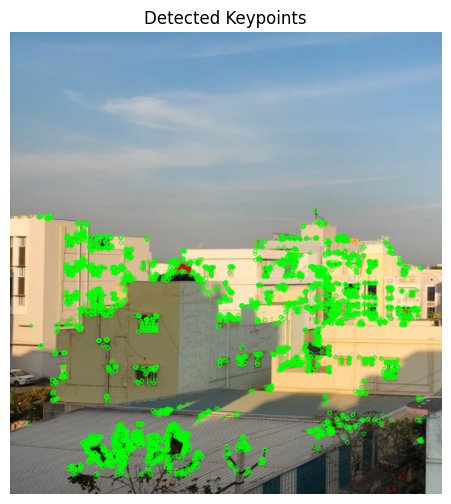

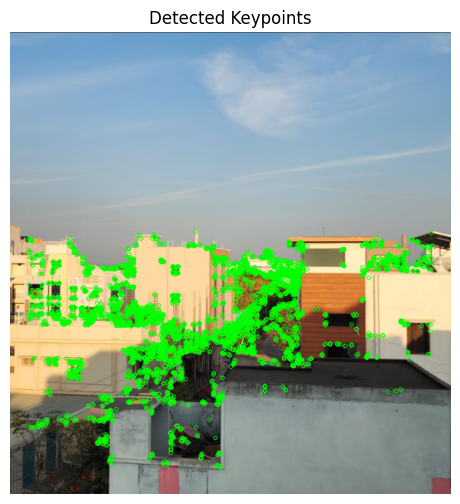

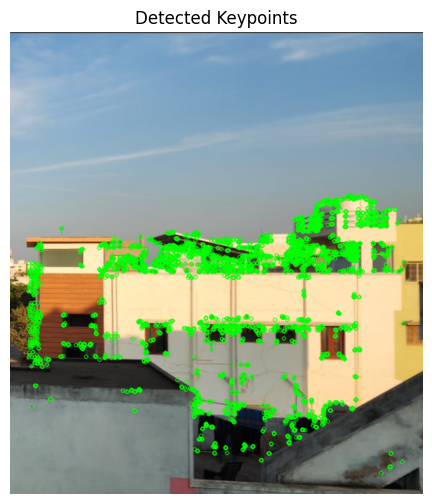

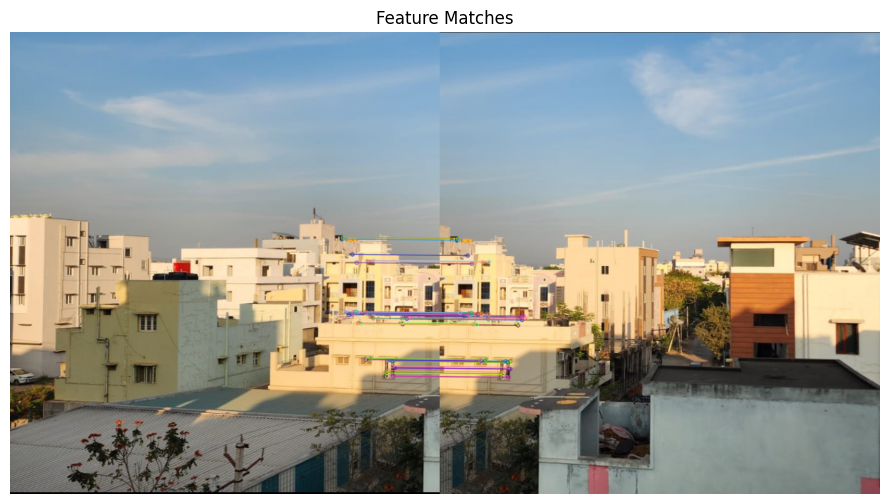

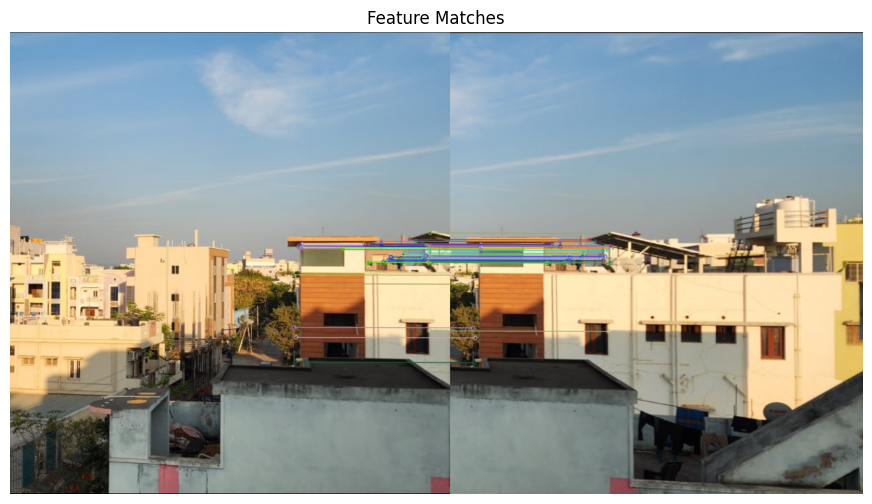

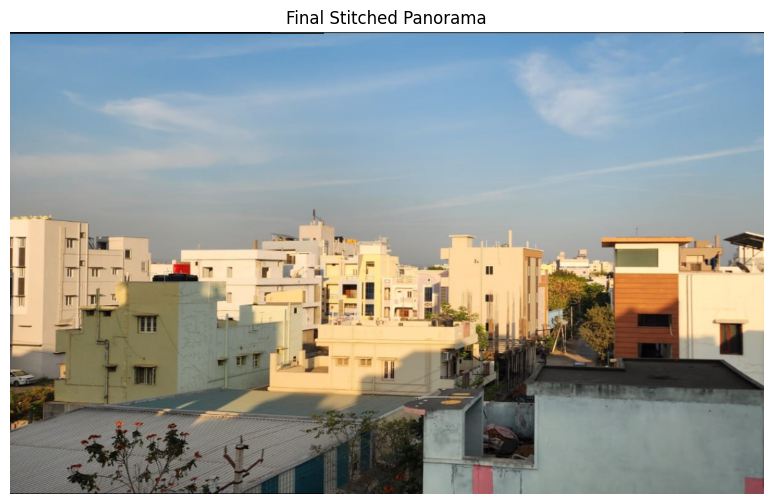

In [13]:
# Provide paths to your 3 overlapping images
image_paths = ["pimg31.png", "pimg32.png", "pimg33.png"]
stitched_panorama = stitch_images(image_paths)